# License

The code in this notebook is free to be used, edited and redistributed by anyone free of charge. Please cite Linssen et al. (in prep) when making use of _sunbather_ and/or the code in this notebook.

# Example goal

In this example notebook, we predict the NUV spectrum of WASP-52 b to see if the signatures of escaping metal species are strong enough to be potentially observable with HST/STIS. In the *fit_helium.ipynb* example notebook, we constrained the mass-loss rate and thermospheric temperature of the planet based on metastable helium observations (the examples can be done in any order). Here, we use those constrained values and make NUV predictions. Since we do not know the (upper) atmospheric metallicity of WASP-52 b, we will explore three different models; one assuming solar metallicity, one assuming 10x solar metallicity, and one assuming 10x solar metallicity but a 100x solar magnesium abundance. 

# Example layout

The analysis consists of three main steps:

- Step 1. Generate Parker wind models at different atmospheric metallicities.
- Step 2. Run the Parker wind models through Cloudy to obtain nonisothermal temperature structures and the chemical state of the atmosphere.
- Step 3. Make synthetic NUV transit spectra of the different models.

Some of the steps we need to take to go through this analysis have to be taken outside of *sunbather* (e.g. storing the planet parameters in the planets.txt file, making the stellar SED available to *Cloudy*). Some steps are part of the "core functionality" of the *sunbather* package, which means they can be executed with a single command-line call to a Python script (e.g. generating the Parker wind profiles, running them through the Cloudy algorithm). And some of the steps are performed inside a user-made Python file/Jupyter notebook (e.g. calculating the transmission spectra). In this notebook, we will provide all neccessary code.

# Preparation

For this exercise, we assume you have all codes set-up. That is; you have downloaded *sunbather* and installed its dependencies (the Python packages, including *p-winds*). You have installed *Cloudy v17.02* and have the path to it stored as your _\$CLOUDY_PATH_ environmental variable. You have created your "project" folder, and have the path to it stored as your _\$SUNBATHER_PROJECT_PATH_ environmental variable. You have copied the _planets.txt_ file to the project path. These steps are described in more detail in the "installation" section of the _sunbather_ wiki.

Before *sunbather* can create Parker wind profiles, we need to make sure the parameters of the system are available to the code. The parameters are stored in the _\$SUNBATHER_PROJECT_PATH/planets.txt_ file, and the parameters of the WASP-52 b system have already been added. If you want to model additional planets, you can simply add lines in the _planets.txt_ file with their parameters, there is no need to replace previous planet parameters. The last column of the _planets.txt_ file specifies the **name** of the stellar SED that we want to use. The SED with exactly this name must be available to *Cloudy*, so it must be placed in its source folder, specifically: _\$CLOUDY_PATH/data/SED/_. In the _/sunbather/stellar_SEDs/_ folder, we have provided the SED that we are going to use for WASP-52 b. This is the MUSCLES spectrum (France et al. 2016; Youngblood et al. 2016; Loyd et al. 2016) of eps Eri, which is a similar spectral type to WASP-52. The code is very specific about the format of the spectrum, so we refer to the wiki on how to prep your stellar SED for *sunbather*. 
> **The only step you need to take here, is make sure the eps_Eri_binned.spec is in Cloudy's SED folder: $CLOUDY_PATH/data/SED/ (so copy/move it there).**

# Step 1: Create Parker wind profiles with p-winds/Cloudy

This step can be done by calling `construct_parker.py` from the command-line with the proper arguments. Running `python construct_parker.py --help` will give an overview of the available arguments. In this module, the atmospheric composition/metallicity only affects the structure through the mean molecular weight $\mu$. At solar metallicity, the metal content is low enough to not significantly affect $\mu$, so we will make the Parker wind profile with *p-winds* standalone, assuming a pure H/He composition of 90/10. At 10x solar metallicity, $\mu$ may be significantly affected by the metal content, so we will make the Parker wind profile with a hybrid *p-winds*/_Cloudy_ calculation. In Step 2 of this example, we will use this profile also for the run with an enhanced magnesium abundance, since $\mu$ (and hence the structure we calculate here in step 1) will not change much when increasing the abundance of just one metal species.

To make the profile with a 90% hydrogen, 10% helium composition, we pass `-fH 0.9`. We will only make a profile for the constrained temperature of 9200 K and mass-loss rate of $\dot{M}=10^{11.3}$ g/s, so we pass `-T 9200` and  `-Mdot 11.3`. Since we explore different compositions, `construct_parker.py` always expects you to give a folder name `-pdir` where we want to store our Parker profiles. We reccommend using a descriptive name, so in this case we will go with *fH_0.9* and the path where our profiles will be saved is then _$SUNBATHER_PROJECT_PATH/parker_profiles/WASP52b/fH_0.9/_.

> **The full command to create our first Parker wind model thus becomes - go ahead and run it**: <br><br>
> `python construct_parker.py -plname WASP52b -pdir fH_0.9 -T 9200 -Mdot 11.3 -fH 0.9`

For this set of parameters, this command should take on the order of 1 second (but it depends on your machine).

To make the 10x solar metallicity profile, instead of the `-fH` argument, we use `-z 10`. We don't want this profile to overwrite the file we just saved for H/He only, so we provide a different `-pdir`. 

> **The full command to create our second Parker wind model thus becomes - go ahead and run it**: <br><br>
> `python construct_parker.py -plname WASP52b -pdir z_10 -T 9200 -Mdot 11.3 -z 10`

For this set of parameters, this command should take on the order of 3 minutes (but it depends on your machine). If it exits with the error that the _Cloudy_ simulation went wrong (because of negative calcium abundance), try again while passing `-zelem Ca=0`.

In the _$SUNBATHER_PROJECT_PATH/parker_profiles/WASP52b/_ folder, there should now be 2 subfolders, each containing a .txt file with the isothermal Parker wind structure, feel free to inspect them!

# Step 2: Run the Parker wind profiles through Cloudy

This step can be done by calling `convergeT_parker.py` from the command-line with the proper arguments The $T_0$ and $\dot{M}$ commands are the same as in Step 1 of this example. We need to specify a folder name where we want to save our *Cloudy* simulations. For the solar composition we will use `-dir z_1`. We also need to specify the folder where we want to read the Parker wind profiles from, so `-pdir fH_0.9`. The last thing we need to think about, is for which atomic/ionic species we want to save *Cloudy's* output. Since many different metal species absorb in the UV, we will save everything that's available (but it does result in a rather large file size):`-save_sp all`.

> **The command to run our solar composition Parker wind model through *Cloudy* thus becomes - go ahead and run it**: <br><br>
> `python convergeT_parker.py -plname WASP52b -dir z_1 -pdir fH_0.9 -T 9200 -Mdot 11.3 -save_sp all`

For the 10x solar metallicity model, we need to make sure we specify `-pdir z_10` to read the Parker wind profile from the correct folder. We will save the _Cloudy_ runs in `-dir z_10`, and we also need to tell _Cloudy_ to actually use a 10x solar metallicity with `-z 10`. 
> **The command to run our 10x solar metallicity Parker wind model through *Cloudy* thus becomes - go ahead and run it**: <br><br>
> `python convergeT_parker.py -plname WASP52b -dir z_10 -pdir z_10 -T 9200 -Mdot 11.3 -save_sp all -z 10`

Finally for the model with 10x solar metallicity, but 100x solar magnesium abundance, we choose a different output folder `-dir z_10_Mg10`, but we can use the same `-pdir` as before (see explanation under Step 1 of this example). Since we already have an overall scaling factor of 10 for all the metals, we have to pass `-zelem Mg=10` to scale magnesium by another factor of 10 to get a 100x solar abundance. For this model, we'll only look at the magnesium spectrum and so do not need to save all species, so we go with `-save_sp Mg Mg+`.
> **The command to run our 10x solar metallicity with enhanced magnesium Parker wind model through *Cloudy* thus becomes - go ahead and run it**: <br><br>
> `python convergeT_parker.py -plname WASP52b -dir z_10_Mg10 -pdir z_10 -T 9200 -Mdot 11.3 -save_sp Mg Mg+ -z 10 -zelem Mg=10`

For these parameters, all commands together should take on the order of 35 minutes (but it depends on your machine). In the *$SUNBATHER_PROJECT_PATH/sims/1D/WASP52b/fH_0.9/* and */.../z_10/* and */.../z_10_Mg10/* folders, there should now be a sub-folder (or more if you also did the _fit_helium.ipynb_ example notebook), with the output of the _Cloudy_ simulation, feel free to inspect the files! The _converged.png_ file shows the converged temperature structure, and the other _converged.*_ files are the _Cloudy_ output files.

# Step 3: Make NUV transit spectra

To make transit spectra, we can make use of the `FinFout()` function in the `RT.py` module. This code does not run from the command line, as you may want to process/plot/save the resulting transit spectrum in different ways.

The `FinFout()` function takes a `Sim` object, which is a class defined in `tools.py`. For more information on how to use this class, we refer to the wiki. The `FinFout()` function takes three required arguments: the `Sim` object, a wavelength array in angstrom and vacuum, and a list of atomic/ionic species which to include in the calculations. There are a few optional arguments (see wiki), for example to specify a limb-darkening law or transit phase, but we will not use those here.

In [1]:
import sys
sys.path.append('/Users/dion/src/sunbather/src/') #add your path to /sunbather/src/ here

import tools
import RT

import matplotlib.pyplot as plt
import numpy as np

Let's start by making the spectrum at solar composition. As a heads-up, there will be a few warnings from _sunbather_. This is expected.

/Users/dion/src/sunbather/src/RT.py:508: UserWarning: Your requested species Ti is not resolved into multiple energy levels by Cloudy. I will make the spectrum assuming all Ti is in the ground-state.
  warnings.warn(f"Your requested species {spec} is not resolved into multiple energy levels by Cloudy. " + \
/Users/dion/src/sunbather/src/RT.py:508: UserWarning: Your requested species Ti+ is not resolved into multiple energy levels by Cloudy. I will make the spectrum assuming all Ti+ is in the ground-state.
  warnings.warn(f"Your requested species {spec} is not resolved into multiple energy levels by Cloudy. " + \
/Users/dion/src/sunbather/src/RT.py:508: UserWarning: Your requested species V is not resolved into multiple energy levels by Cloudy. I will make the spectrum assuming all V is in the ground-state.
  warnings.warn(f"Your requested species {spec} is not resolved into multiple energy levels by Cloudy. " + \
/Users/dion/src/sunbather/src/RT.py:508: UserWarning: Your requested spec

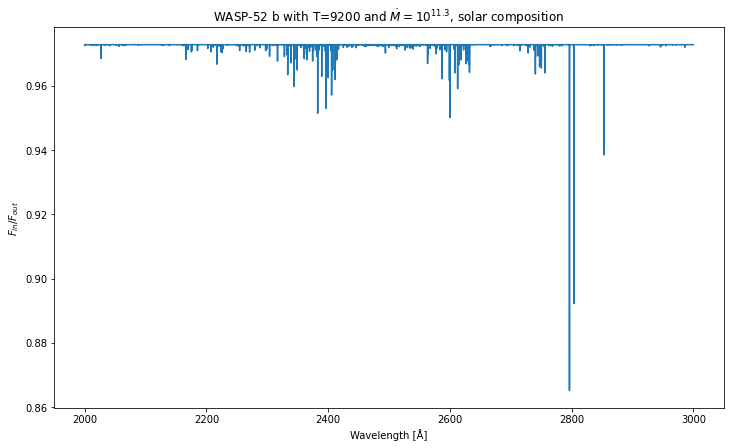

In [2]:
wavs = RT.constantR_wavs(2000,3000,100000) #set up wavelength grid at spectral resolution of 100,000
W52b_solar = tools.Sim(tools.projectpath+'/sims/1D/WASP52b/z_1/parker_9200_11.300/converged') #load simulation
#we can quickly get a list of all species as follows:
all_species = tools.get_specieslist(max_ion=2) #this includes all species up to doubly ionized - higher is not neccessary here
transit_spectrum_solar, _, _ = RT.FinFout(W52b_solar, wavs, all_species) #do RT

fig, ax = plt.subplots(1, figsize=(12,7))
ax.plot(wavs, transit_spectrum_solar)
ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel(r'$F_{in} / F_{out}$')
ax.set_title(r'WASP-52 b with T=9200 and $\dot{M}=10^{11.3}$, solar composition')
plt.show()

Now let's do 10x solar metallicity.

/Users/dion/src/sunbather/src/RT.py:508: UserWarning: Your requested species Ti is not resolved into multiple energy levels by Cloudy. I will make the spectrum assuming all Ti is in the ground-state.
  warnings.warn(f"Your requested species {spec} is not resolved into multiple energy levels by Cloudy. " + \
/Users/dion/src/sunbather/src/RT.py:508: UserWarning: Your requested species Ti+ is not resolved into multiple energy levels by Cloudy. I will make the spectrum assuming all Ti+ is in the ground-state.
  warnings.warn(f"Your requested species {spec} is not resolved into multiple energy levels by Cloudy. " + \
/Users/dion/src/sunbather/src/RT.py:508: UserWarning: Your requested species V is not resolved into multiple energy levels by Cloudy. I will make the spectrum assuming all V is in the ground-state.
  warnings.warn(f"Your requested species {spec} is not resolved into multiple energy levels by Cloudy. " + \
/Users/dion/src/sunbather/src/RT.py:508: UserWarning: Your requested spec

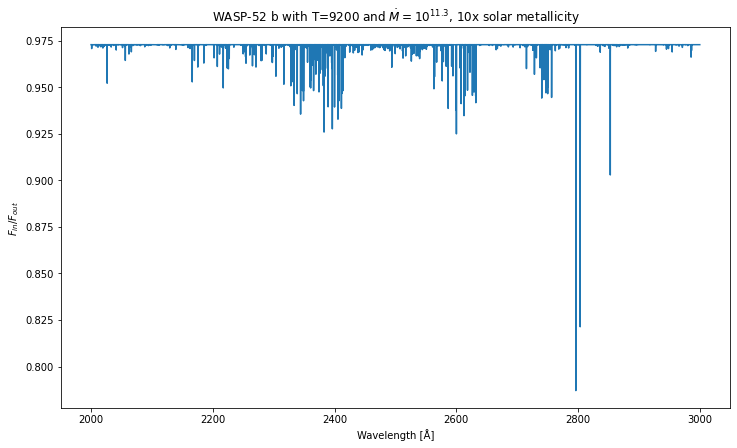

In [3]:
W52b_z_10 = tools.Sim(tools.projectpath+'/sims/1D/WASP52b/z_10/parker_9200_11.300/converged') #load simulation
transit_spectrum_z_10, _, _ = RT.FinFout(W52b_z_10, wavs, all_species) #do RT

fig, ax = plt.subplots(1, figsize=(12,7))
ax.plot(wavs, transit_spectrum_z_10)
ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel(r'$F_{in} / F_{out}$')
ax.set_title(r'WASP-52 b with T=9200 and $\dot{M}=10^{11.3}$, 10x solar metallicity')
plt.show()

And finally a zoom-in on the magnesium doublet for all three models together: solar composition, 10x solar composition, and the model with a 100x solar magnesium abundance. 

A technical detail that is important here: To save computational time, `RT.FinFout()` function calculates each individual spectral line in a narrow wavelength window (i.e. only a subset of `wavs`) around the rest-frame wavelength of that line. In the absolute majority of cases, this window is large enough to encompass the whole spectral line, but not in special cases where the line is very strong, such as commonly for the Ly-$\alpha$ line, or here for the Mg II doublet in the 100x solar abundance model. You could visually see this in the resulting spectrum as a discrete "jump" from the line wing to the continuum. In such a case, we have to manually increase the computation window by a certain factor with the `width_fac` argument. We will set it to 20 here to catch the full Lorentzian wing of the line (try without it to check the difference!).

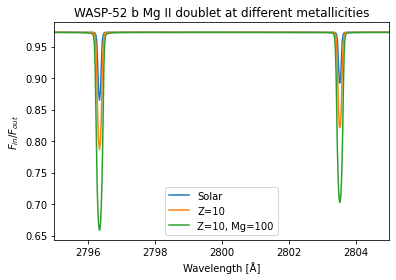

In [4]:
wavs2 = np.linspace(2795, 2805, num=500) #set up a wav-grid around the Mg II doublet
W52b_z_10_Mg10 = tools.Sim(tools.projectpath+'/sims/1D/WASP52b/z_10_Mg10/parker_9200_11.300/converged') #load simulation
transit_spectrum_z_10_Mg10, _, _ = RT.FinFout(W52b_z_10_Mg10, wavs2, 'Mg+', width_fac=20.) #do RT

fig, ax = plt.subplots(1)
ax.plot(wavs, transit_spectrum_solar, label='Solar')
ax.plot(wavs, transit_spectrum_z_10, label='Z=10')
ax.plot(wavs2, transit_spectrum_z_10_Mg10, label='Z=10, Mg=100')
ax.set_xlim(wavs2[0], wavs2[-1])
ax.legend(loc='best')
ax.set_title(r'WASP-52 b Mg II doublet at different metallicities')
ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel(r'$F_{in} / F_{out}$')
plt.show()

To predict the actual observability of these lines in WASP-52 b, we would first need to convolve the spectrum down to the HST/STIS resolution and then do a S/N calculation based on the system magnitude, exposure time, etc. This is outside the scope of this example problem.

### References

France, K., Loyd, R. O. P., Youngblood, A., et al. 2016, ApJ, 820, 89

Loyd, R. O. P., France, K., Youngblood, A., et al. 2016, ApJ, 824, 102

Youngblood, A., France, K., Loyd, R. O. P., et al. 2016, ApJ, 824, 101